In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from toolkit import trappist1, transit_model, trappist_out_of_transit

g = trappist1('g')

C1 = BJD_UTC-2450000

C2 = flux

C3 = error

C4 = X

C5 = Y

C6 = fwhm

C7 = fwhm-x

C8 = fwhm-y

C9 = background

C10 = airmass, irrelevant here

C11 = exposure time (subarray)

> To model this light curve, I use a linear function of X, Y, fwhm-x, and fwhm-y, plus a transit model.


In [3]:
bjd, flux, err, x, y, fwhm, fwhmx, fwhmy, bg, airmass, exptime = np.loadtxt('phot0002.txt', unpack=True)
bjd += 2450000

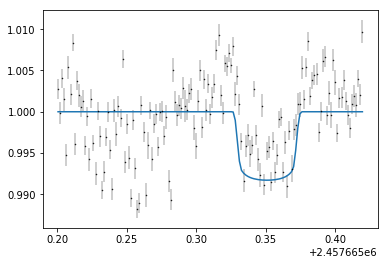

In [8]:
plt.errorbar(bjd, flux/np.median(flux), err, fmt='.', color='k', ms=1, ecolor='silver')

transit_model_g = transit_model(bjd, g)
oot = transit_model_g == 1

plt.plot(bjd, transit_model_g)
# plt.plot(bjd[oot], transit_model_g[oot], '.')

In [28]:
from toolkit import transit_duration

g.inc

89.721

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 165


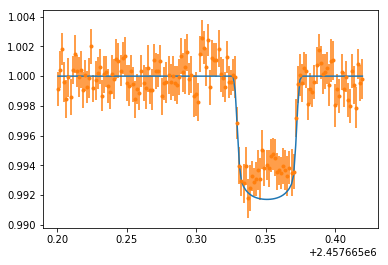

In [33]:
X_all = np.vstack([x, y, fwhmx, fwhmy]).T

X = X_all[oot, :]

omega = np.diag(err[oot]**2)
omega_inv = np.linalg.inv(omega)

V = np.linalg.inv(X.T @ omega_inv @ X)
beta = V @ X.T @ omega_inv @ flux[oot]

regressed_lc = flux - (X_all @ beta) + 1
plt.plot(bjd, transit_model_g)

from scipy.optimize import fmin_powell

def minimize(p):
    return abs(np.sum((regressed_lc - transit_model_g)**2 / (p[0] * err)**2)/len(regressed_lc) - 1)

err_scale = fmin_powell(minimize, [1])

plt.errorbar(bjd, regressed_lc, err_scale*err, fmt='.')

np.savetxt('lightcurve.txt', np.vstack([bjd, regressed_lc, err_scale*err]).T)

Compare with the lightcurve from Michael: 
![](./gillon.png)

In [29]:
def quadratic_to_nonlinear(u1, u2):
    a1 = a3 = 0
    a2 = u1 + 2*u2
    a4 = -u2
    return (a1, a2, a3, a4)

quadratic_to_nonlinear(*g.u)

(0, 0.648, 0, -0.244)

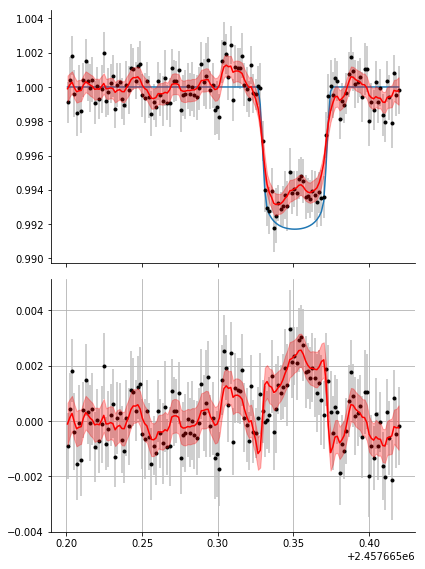

In [59]:
import celerite
from celerite import terms
from scipy.optimize import minimize
from celerite.modeling import Model
from copy import deepcopy

original_params = g
times = bjd 
fluxes = regressed_lc
errors = err

class MeanModel3Param(Model):
    parameter_names = ['amp', 'depth', 't0']

    def get_value(self, t):
        params = deepcopy(trappist1('b'))
        params.rp = self.depth**0.5
        params.t0 = self.t0 + original_params.t0
        return self.amp * transit_model(t, params)

initp_dict = dict(amp=1, depth=original_params.rp**2,
                  t0=0)#t0=original_params.t0)

parameter_bounds = dict(amp=[0.9*np.min(fluxes), 1.3*np.max(fluxes)],
                        depth=[0.9 * original_params.rp**2,
                               1.1 * original_params.rp**2],
                        t0=[-0.05, 0.05])

mean_model = MeanModel3Param(bounds=parameter_bounds, **initp_dict)

bounds = dict(log_a=(-30, 30))#, log_c=(np.log(4), np.log(8)))

log_c_median = 1.98108915

kernel = terms.RealTerm(log_a=-2, log_c=log_c_median,
                        bounds=bounds)
kernel.freeze_parameter('log_c')

gp = celerite.GP(kernel, mean=mean_model, fit_mean=True)
gp.compute(times - original_params.t0, errors)

# Define a cost function
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

# Fit for the maximum likelihood parameters
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
soln = minimize(neg_log_like, initial_params, #jac=grad_neg_log_like,
                method="L-BFGS-B", bounds=bounds, args=(fluxes, gp))
gp.set_parameter_vector(soln.x)

mu, var = gp.predict(fluxes, times - original_params.t0, return_var=True)
std = np.sqrt(var)

fig, ax = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
ax[0].errorbar(times, fluxes, errors, fmt='.', color='k', ecolor='silver')
ax[0].fill_between(times, mu-std, mu+std, color='r', zorder=10, alpha=0.3)
ax[0].plot(times, mu, color='r', zorder=10)
ax[0].plot(bjd, transit_model_g)

ax[1].errorbar(times, fluxes - transit_model_g, errors, fmt='.', color='k', ecolor='silver')
ax[1].fill_between(times, mu-std-transit_model_g, mu+std-transit_model_g, color='r', zorder=10, alpha=0.3)
ax[1].plot(times, mu - transit_model_g, color='r', zorder=10)
ax[1].grid()

for axis in ax: 
    for j in ['right', 'top']:
        axis.spines[j].set_visible(False)

fig.tight_layout()
plt.show()